<h1>Session 8. Partial Least Squares Regression</h1>
<p>This notebook provides an example code of predicting price of cars using <b>partial least square regression</b> with Automobile data. 
There is only one dependent variable-<b>Price</b> so we will use <b>PLS1</b> regression method. (PLS2 is for more than one dependent variables (Y))
<br>

The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, 0 variance,summary statistics of our variables, etc)
<li>Separate data into numeric and objec datasets, so to be able to create dummy variables
<li>Checking for correlations between numeric variables, and see that there are many correlated variables, so using Linear Regression will arise multicollinearity issue 
<li>Devide data into training and testing sets
<li>Construct the PLS model using sklearn
<li>Get R-square of the model
<li>Get Variance change per each latent variable, and see visually the optimal number of latent variables that can be kept in the model
<li>Compare the results of PLS and Linear regression
</ol>
</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.api import qqplot
from statsmodels.formula.api import ols #for linear regression
import seaborn as sns #for heatmap
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale 

In [2]:
#read data
data=pd.read_csv("Automobile_data.csv")

In [3]:
data.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_of_doors         203 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_of_cylinders     205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    205 non-null float64
horsepower           203 non-null float64
peak_rpm             203 non-null float64
city_mpg             205 no

In [5]:
data.isnull().any() #we should drop missing values, as there are variables that have N/As

make                 False
fuel_type            False
aspiration           False
num_of_doors          True
body_style           False
drive_wheels         False
engine_location      False
wheel_base           False
length               False
width                False
height               False
curb_weight          False
engine_type          False
num_of_cylinders     False
engine_size          False
fuel_system          False
bore                  True
stroke                True
compression_ratio    False
horsepower            True
peak_rpm              True
city_mpg             False
highway_mpg          False
price                 True
dtype: bool

In [6]:
#drop missing values
data=data.dropna()

In [7]:
#separate data into numeric and object subsets
data_numeric = data.select_dtypes(exclude="object")
data_object = data.select_dtypes(include="object")

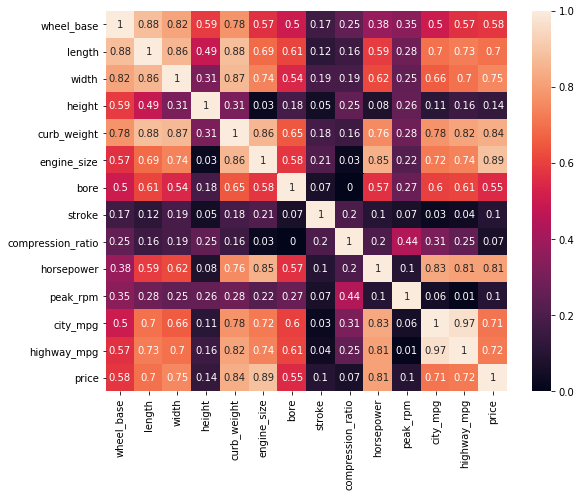

In [8]:
#we can see that there are many correlated variables
plt.figure(figsize=(9, 7)) #make the graph bigger
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

In [9]:
#check for 0 variance, as we can see there are no variables with 0 variance, so we will keep all numeric variables
data_numeric.var()==0

wheel_base           False
length               False
width                False
height               False
curb_weight          False
engine_size          False
bore                 False
stroke               False
compression_ratio    False
horsepower           False
peak_rpm             False
city_mpg             False
highway_mpg          False
price                False
dtype: bool

In [10]:
#check for unique values of categorical variables
for i in data_object.columns:
    print(data_object[i].unique())

['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'peugot'
 'plymouth' 'porsche' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']
['gas' 'diesel']
['std' 'turbo']
['two' 'four']
['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
['rwd' 'fwd' '4wd']
['front' 'rear']
['dohc' 'ohcv' 'ohc' 'l' 'ohcf']
['four' 'six' 'five' 'three' 'twelve' 'eight']
['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' 'idi' 'spdi']


In [11]:
#as sklearn doesn't automatically convert categories of object variables into dummy variables
data_dummy = pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)

In [12]:
data_dummy.head()

,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,...,num_of_cylinders_four,num_of_cylinders_six,num_of_cylinders_three,num_of_cylinders_twelve,fuel_system_2bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
#let's join the numeric and dummy variables back (by index)
data = data_numeric.join(data_dummy)

In [14]:
#let's define what are our X and Y variables
Y=data.price
X=scale(data.drop(columns="price")) #we should normalize (scale) the X data befor running pls

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 204
Data columns (total 59 columns):
wheel_base                 193 non-null float64
length                     193 non-null float64
width                      193 non-null float64
height                     193 non-null float64
curb_weight                193 non-null int64
engine_size                193 non-null int64
bore                       193 non-null float64
stroke                     193 non-null float64
compression_ratio          193 non-null float64
horsepower                 193 non-null float64
peak_rpm                   193 non-null float64
city_mpg                   193 non-null int64
highway_mpg                193 non-null int64
price                      193 non-null float64
make_audi                  193 non-null uint8
make_bmw                   193 non-null uint8
make_chevrolet             193 non-null uint8
make_dodge                 193 non-null uint8
make_honda                 193 non-null uint8
m

In [16]:
# split 75% train and 25% test
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [17]:
#run pls model, we define the number of latent variables we want to keep in the model
pls = PLSRegression(14)
pls=pls.fit(x_train,y_train)

In [18]:
#let's use the model to do prediction for test data
pred=pls.predict(x_test)

In [19]:
#R-square
pls_r2=pls.score(x_test,y_test)
pls_r2

0.9042486358990026

In [20]:
#this gives all coefs per all 58 X variables
coef=pd.DataFrame(pls.coef_)
coef.head()

,0
0,1853.255727
1,-1192.371365
2,880.172245
3,-694.374502
4,2294.371063


In [21]:
#scores of latent variables
sc=pd.DataFrame(pls.x_scores_)
sc.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-3.433320,-0.176857,0.824141,-0.895387,-1.218353,1.226609,-1.648470,1.062604,0.660011,-0.322489,0.507540,-1.075006,-0.031349,-0.414740
1,-4.330832,1.790565,0.361683,-0.131705,0.448625,-0.621482,0.189363,0.185083,-0.890425,-0.237913,0.783366,-0.188789,-1.098296,0.703182
2,-2.479803,-0.254193,-3.048170,2.686994,0.461518,1.173217,-0.324596,-0.986013,-0.518027,-0.273686,0.237148,-0.438713,-0.150748,0.356279
3,1.645651,-0.418485,-0.183017,-0.586288,-1.808144,-1.483844,0.272358,1.195819,-1.182685,-0.042218,-0.605276,-1.106066,-0.015349,-0.036060
4,-1.851599,0.724931,-0.570809,-0.566040,-0.675670,-1.620077,0.169243,1.604793,-0.950464,0.658175,0.442213,-0.605015,0.013495,0.332749
5,-0.473723,-0.997241,0.026305,0.415180,-0.597346,-0.121187,0.423153,-0.557978,0.326630,1.087279,0.130977,0.282233,0.643739,-0.608743
6,-1.992775,0.182993,-0.386001,-0.365725,-0.506689,-1.108859,-0.229451,-0.852513,-1.279661,-0.343633,0.788496,0.656203,-0.179162,0.636219
7,-3.698946,1.414302,0.196178,-0.267388,0.231590,-0.970890,0.110707,0.158795,-1.137566,-0.561874,0.422549,-0.441429,-1.473923,0.242976
8,0.867911,0.591211,2.148038,2.620782,-2.305301,-0.341413,0.721079,1.403980,-0.163382,-0.046572,-0.104866,0.680401,2.442518,0.526843
9,2.982918,1.123054,-0.502065,-0.946337,0.326016,0.445819,-0.595535,-0.227821,-0.768800,0.550725,-0.856589,1.401360,1.001589,-1.476400


<h3>we want to calculate how much of the variance of all X variables is explained by each latent variable</h3>

In [22]:
#first we need to calculate the variance for each latent variable created
var_xcores=np.var(pls.x_scores_,axis=0)
var_xcores

array([10.23541948,  2.55232414,  2.68955472,  1.73187538,  1.05178474,
        1.23728727,  1.34266882,  1.17193835,  0.74222052,  0.57954627,
        0.6514719 ,  0.92187617,  0.79404217,  0.42087634])

In [23]:
#second, lets calculate total variance of all X variables
total_var=np.sum(np.var(x_train,axis=0))
total_var

54.68950987170588

In [24]:
#calculate the proportioan of total X variance explained by each latent variable
X_Variance=pd.DataFrame((var_xcores/total_var).round(3), columns={"X_Variance"}).reset_index()

In [25]:
#let's keep X_variance i=and cummulative X_Variance as dataframe
X_Variance = X_Variance.rename(columns={'index': 'Latent_Factors'})
X_Variance['Cummulative_X_Variance'] = X_Variance['X_Variance'].cumsum().round(3) #calculates cummulative variance
X_Variance

,Latent_Factors,X_Variance,Cummulative_X_Variance
0,0,0.187,0.187
1,1,0.047,0.234
2,2,0.049,0.283
3,3,0.032,0.315
4,4,0.019,0.334
5,5,0.023,0.357
6,6,0.025,0.382
7,7,0.021,0.403
8,8,0.014,0.417
9,9,0.011,0.428


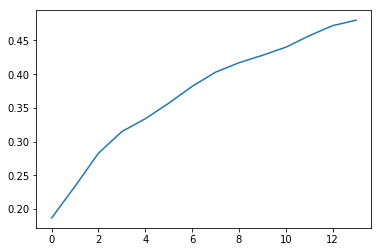

In [26]:
#we want to see visually from which latent variable the variance changes very slightly
plt.plot(X_Variance.Latent_Factors,X_Variance.Cummulative_X_Variance)

# Linear Regression

In [27]:
#let's use sklearn to run linear regression and calculate R-square
lin_reg=LinearRegression().fit(X,Y)
pr_l=lin_reg.predict(x_test)
Linear_r2=r2_score(y_test,pr_l)
Linear_r2

0.9631438719699826

In [28]:
#comparison of R-Square of pls and linear regression
(pls_r2,Linear_r2)

(0.9042486358990026, 0.9631438719699826)